In [213]:
import numpy as np
import os
import optuna
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures


from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

### Loading Data

In [193]:
PATH_DATA = "data/"
X_train = np.load(os.path.join(PATH_DATA, "X_train.npy"))
X_test = np.load(os.path.join(PATH_DATA, "X_test.npy"))
y_train = np.load(os.path.join(PATH_DATA, "y_train.npy"))
y_test = np.load(os.path.join(PATH_DATA, "y_test.npy"))

X_train.shape, y_test.shape, X_test.shape, y_test.shape

((500, 30), (500,), (500, 30), (500,))

### Visualizing Data

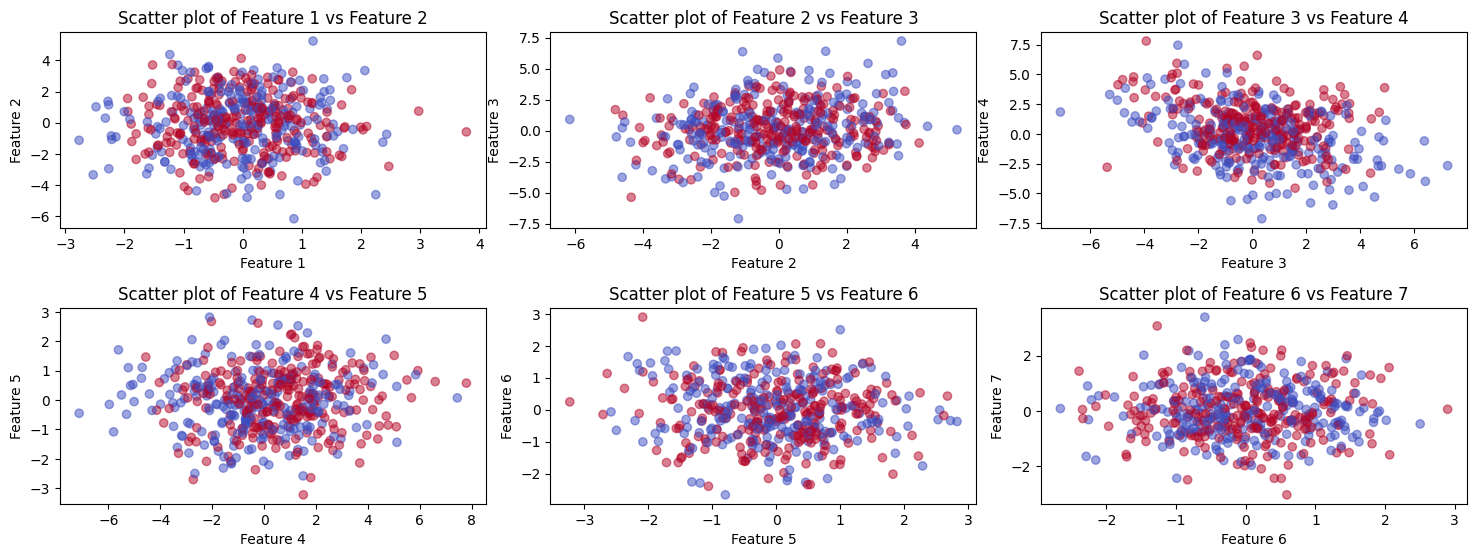

In [195]:
plt.figure(figsize=(15, 8))
for i in range(1, 7):
    plt.subplot(3, 3, i)
    plt.scatter(X_train[:, i], X_train[:, i+1], c=y_train, cmap='coolwarm', alpha=0.5)
    plt.xlabel(f'Feature {i}')
    plt.ylabel(f'Feature {i+1}')
    plt.title(f'Scatter plot of Feature {i} vs Feature {i+1}')
plt.tight_layout()
plt.show()

### Data seems non linear
Just by looking at a few features, we can tell that the data is probably non-linear.\
If we want good results we may need to use a non linear classifier

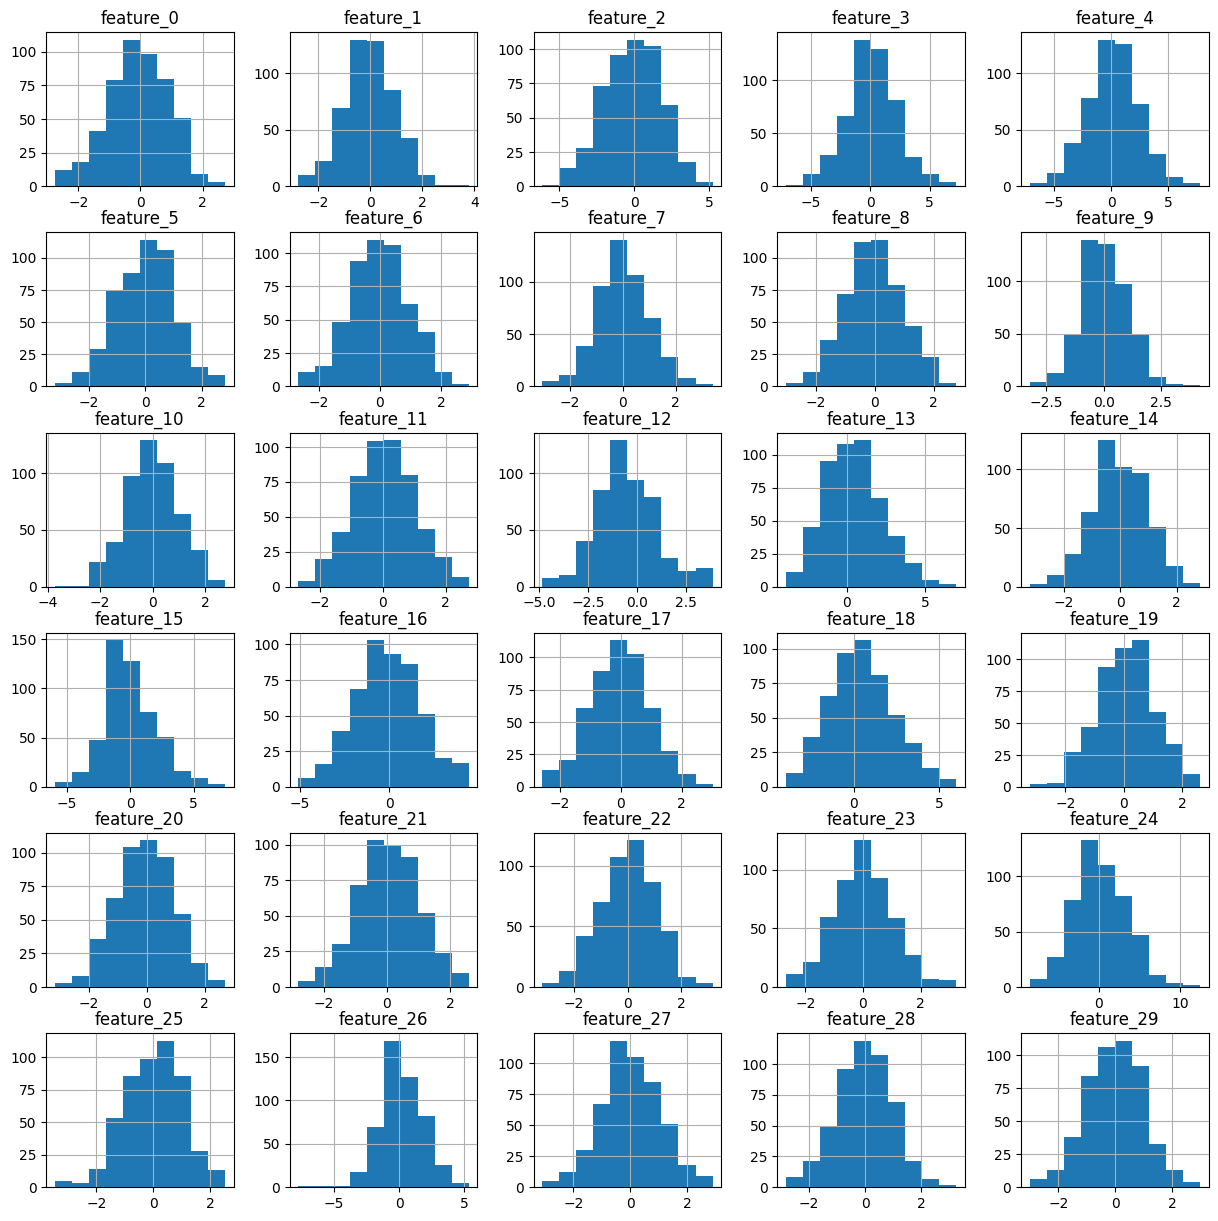

In [254]:
feature_names = [f'feature_{i}' for i in range(X_train.shape[1])]
df = pd.DataFrame(X_train, columns=feature_names)

df.hist(figsize=(15, 15))
plt.show()

### Data distribution
The data seems to follow a gaussian distribution There is probably no point to standardize our values

### Feature Engineering
 explain why polynomial 3 is good??


### Model
We test a simple regression model but with polynomial features

In [228]:
result_accuracy = []

def logistic_regression_model(result_accuracy, X_train, y_train, X_test, name):
    logistic_model = LogisticRegression(max_iter=1000)
    logistic_model.fit(X_train, y_train)
    y_pred_logistic = logistic_model.predict(X_test)
    logistic_accuracy = accuracy_score(y_test, y_pred_logistic)
    result_accuracy.append([name, logistic_accuracy])

logistic_regression_model(result_accuracy, X_train, y_train, X_test, name="classic_logistic_reg")

for i in range(1, 5):
    poly = PolynomialFeatures(degree=i)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    logistic_regression_model(result_accuracy, X_train_poly, y_train, X_test_poly, name=f"poly_deg{i}_logistic_reg")


results_df = pd.DataFrame(result_accuracy, columns=["classifier", "accuracy_test"])
results_df

,classifier,accuracy_test
0,classic_logistic_reg,0.800
1,poly_deg1_logistic_reg,0.800
2,poly_deg2_logistic_reg,0.722
3,poly_deg3_logistic_reg,0.904
4,poly_deg4_logistic_reg,0.780


In [255]:
poly = PolynomialFeatures(degree=3)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train_poly, y_train)
y_pred_logistic = logistic_model.predict(X_test_poly)
print(classification_report(y_test, y_pred_logistic))

              precision    recall  f1-score   support

           0       0.84      0.95      0.89       201
           1       0.96      0.88      0.92       299

    accuracy                           0.90       500
   macro avg       0.90      0.91      0.90       500
weighted avg       0.91      0.90      0.90       500



### Now Let's use a SVM with polynomial kernal

In [256]:
svm_classifier = SVC(kernel='poly')
svm_classifier.fit(X_train, y_train)
y_pred = svm_classifier.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.74      0.80       201
           1       0.84      0.93      0.88       299

    accuracy                           0.85       500
   macro avg       0.85      0.83      0.84       500
weighted avg       0.85      0.85      0.85       500



In [257]:
def objective_SVM(trial: optuna.trial.Trial):
    t_C = trial.suggest_float("C", 0.1, 1, step=0.01)
    t_gamma = trial.suggest_categorical("gamma", ["scale", "auto"])
    t_kernel = trial.suggest_categorical("kernel", [ "poly", "rbf", "sigmoid"])

    svm_classifier = SVC(
        C=t_C,
        gamma=t_gamma,
        kernel=t_kernel,
    ) 
    
    svm_classifier.fit(X_train, y_train)
    y_pred = svm_classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

In [258]:
storage_name = "classification.db"
if os.path.exists(storage_name):
    os.remove(storage_name)

optuna.logging.set_verbosity(optuna.logging.WARNING)

study = optuna.create_study(
        storage=f"sqlite:///{storage_name}",
        study_name="Classification",
        load_if_exists=False,
        direction="maximize",
)

study.optimize(func=objective_SVM, n_trials=100)

In [259]:
print(f"Best obtrained accuracy: {study.best_trial.values}\nWith the following parameters: {study.best_trial.params}" )

Best obtrained accuracy: [0.984]
With the following parameters: {'C': 0.89, 'gamma': 'auto', 'kernel': 'poly'}


### why?

it seems regu;arization and gama play an important role.
